# Classification de séquences par réseaux récurrents
Objectif : classification de données binaires (avis positifs/négatifs sur des films)

## Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, LSTM, Dense


## Chargement des données
Base de données IMDB (avis positif/négatif sur les films). On ne s'intéresse qu'aux 10000 mots les plus courants. On charge également la correspondance mot-> identifiant (id)

In [2]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)
word_index = imdb.get_word_index()

1641221/1641221 [==============================] - 0s 0us/step


On créé une correspondance inverse id->mot en ajoutant des mots spéciaux

In [3]:
index = {word_id + 3: word for word, word_id in word_index.items()}
index[0] = "<pad>" # padding
index[1] = "<sos>" # début de séquence
index[2] = "<oov>" # hors vocabulaire
index[3] = "<unk>" # inconnu

Fonction de lecture des avis

In [4]:
def decode_review(word_ids):
    return " ".join([index.get(word_id, "<err>") for word_id in word_ids])

print("Un exemple d'avis : ",decode_review(X_train[10]))
print("Avis positif (1)/négatif (0) : ",y_train[1])

Un exemple d'avis :  <sos> french horror cinema has seen something of a revival over the last couple of years with great films such as inside and <oov> romance <oov> on to the scene <oov> <oov> the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made <oov> was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is <oov> by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named <oov> sent to prison for fraud he is put in a cell with three others the quietly insane <oov> body building <oov> marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old <oov> after <oov> part of it they soon realise its magical powers and realise they may

## Modèle de référence
Pour évaluer le modèle RNN, on construit un modèle de référence sur lequel comparer les résultats. Le code vous est fourni

In [5]:
X_train_text = [decode_review(words_ids) for words_ids in X_train]
X_test_text = [decode_review(words_ids) for words_ids in X_test]

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

In [7]:
processing = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', SGDClassifier(max_iter=50)),])

In [8]:
processing.fit(X_train_text, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(max_iter=50))])

In [9]:
print("Précision du modèle de référence : ",processing.score(X_test_text, y_test))
print("Test du modèle (avis 0 attendu ) : ", processing.predict(["this movie was really awful"]))
print("Test du modèle (avis 1 attendu ) : ", processing.predict(["this movie was really fantastic"]))

Précision du modèle de référence :  0.885
Test du modèle (avis 0 attendu ) :  [0]
Test du modèle (avis 1 attendu ) :  [1]


## Classification de séquences par réseau récurrent

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 500

# Créer un objet Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_text)

# Convertir les textes en séquences d'entiers
X_train_sequences = tokenizer.texts_to_sequences(X_train_text)
X_test_sequences = tokenizer.texts_to_sequences(X_test_text)

# Appliquer pad_sequences pour obtenir la matrice 2D
padded_sequences_train = pad_sequences(X_train_sequences, maxlen=maxlen)
padded_sequences_test = pad_sequences(X_test_sequences, maxlen=maxlen)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# Créer un modèle Sequential
model = Sequential()

# Ajouter une couche d'Embedding
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=10, input_length=maxlen))

# Ajouter une couche LSTM avec 32 neurones
model.add(LSTM(32))

# Ajouter une couche dense de sortie avec activation sigmoid (classification binaire)
model.add(Dense(1, activation='sigmoid'))

# Compiler le modèle avec la fonction de perte binaire_crossentropy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

X_train_trim = padded_sequences_train
X_test_trim = padded_sequences_test


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 10)           99990     
                                                                 
 lstm (LSTM)                 (None, 32)                5504      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 105527 (412.21 KB)
Trainable params: 105527 (412.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
history = model.fit(X_train_trim, y_train,epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 37s 185ms/step - loss: 0.6334 - accuracy: 0.6414 - val_loss: 0.5962 - val_accuracy: 0.7112
Epoch 2/10
157/157 [==============================] - 24s 154ms/step - loss: 0.3673 - accuracy: 0.8485 - val_loss: 0.3043 - val_accuracy: 0.8764
Epoch 3/10
157/157 [==============================] - 18s 113ms/step - loss: 0.2219 - accuracy: 0.9183 - val_loss: 0.2775 - val_accuracy: 0.8872
Epoch 4/10
157/157 [==============================] - 14s 88ms/step - loss: 0.1771 - accuracy: 0.9363 - val_loss: 0.2995 - val_accuracy: 0.8904
Epoch 5/10
157/157 [==============================] - 10s 63ms/step - loss: 0.1308 - accuracy: 0.9571 - val_loss: 0.3281 - val_accuracy: 0.8628
Epoch 6/10
157/157 [==============================] - 9s 57ms/step - loss: 0.1144 - accuracy: 0.9626 - val_loss: 0.3327 - val_accuracy: 0.8874
Epoch 7/10
157/157 [==============================] - 10s 62ms/step - loss: 0.0952 - accuracy: 0.9697 - val_loss: 0.3364 - val_accurac

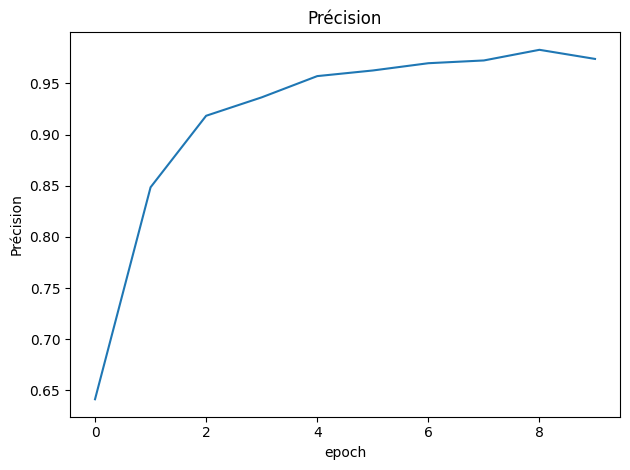

In [13]:
plt.plot(history.history['accuracy'])
plt.title('Précision')
plt.ylabel('Précision')
plt.xlabel('epoch')
plt.tight_layout()

In [14]:
model.evaluate(X_test_trim, y_test)
print("Test du modèle (avis 0 attendu ) : ", processing.predict(["this movie was really awful"]))
print("Test du modèle (avis 1 attendu ) : ", processing.predict(["this movie was really fantastic"]))

782/782 [==============================] - 7s 8ms/step - loss: 0.4653 - accuracy: 0.8562
Test du modèle (avis 0 attendu ) :  [0]
Test du modèle (avis 1 attendu ) :  [1]


## Utilisation d'un réseau bidirectionnel

In [15]:
from tensorflow.keras.layers import Dropout, Bidirectional

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# Créer un modèle Sequential
model = Sequential()

# Ajouter une couche d'Embedding
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=10, input_length=maxlen))

# Ajouter une couche LSTM bidirectionnelle avec 32 neurones
model.add(Bidirectional(LSTM(32)))

# Ajouter une couche de Dropout pour éviter le surapprentissage
model.add(Dropout(0.5))

# Ajouter une couche dense de sortie avec activation sigmoid (classification binaire)
model.add(Dense(1, activation='sigmoid'))

X_train_trim = padded_sequences_train
X_test_trim = padded_sequences_test

In [16]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [17]:
history = model.fit(X_train_trim, y_train,epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 30s 155ms/step - loss: 0.6751 - accuracy: 0.5719 - val_loss: 0.5547 - val_accuracy: 0.7742
Epoch 2/10
157/157 [==============================] - 19s 119ms/step - loss: 0.4706 - accuracy: 0.8027 - val_loss: 0.5464 - val_accuracy: 0.7404
Epoch 3/10
157/157 [==============================] - 15s 94ms/step - loss: 0.3362 - accuracy: 0.8658 - val_loss: 0.3621 - val_accuracy: 0.8496
Epoch 4/10
157/157 [==============================] - 12s 78ms/step - loss: 0.2720 - accuracy: 0.8955 - val_loss: 0.2951 - val_accuracy: 0.8794
Epoch 5/10
157/157 [==============================] - 11s 68ms/step - loss: 0.2386 - accuracy: 0.9143 - val_loss: 0.3403 - val_accuracy: 0.8776
Epoch 6/10
157/157 [==============================] - 9s 57ms/step - loss: 0.2057 - accuracy: 0.9251 - val_loss: 0.2922 - val_accuracy: 0.8828
Epoch 7/10
157/157 [==============================] - 9s 60ms/step - loss: 0.1887 - accuracy: 0.9348 - val_loss: 0.3440 - val_accuracy:

In [18]:
model.evaluate(X_test_trim, y_test)
print("Test du modèle (avis 0 attendu ) : ", processing.predict(["this movie was really awful"]))
print("Test du modèle (avis 1 attendu ) : ", processing.predict(["this movie was really fantastic"]))

782/782 [==============================] - 12s 15ms/step - loss: 0.3515 - accuracy: 0.8742
Test du modèle (avis 0 attendu ) :  [0]
Test du modèle (avis 1 attendu ) :  [1]
